In [ ]:
!pip install wandb

In [ ]:
import wandb
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from PIL import Image
from pathlib import Path
import tqdm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from scipy import integrate

In [ ]:
config = dict(n_epochs = 50,
              batch_size = 32,
              learning_rate = 1e-4,
              num_workers = 4,
              channels = 1,
              image_size = 28,
              path = 'mnist.pth')

In [1]:
# wandb setup
#wandb.login(key="------")
# run = wandb.init(
#     project="RDMC",
#     name="mnist",
#     config = config)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

#%cd '/dir/to/project''
#!pwd

In [ ]:
#@title Defining a time-dependent score-based model

class GaussianFourierProjection(nn.Module):

  def __init__(self, embed_dim, scale=30.):
    super().__init__()

    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):

  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):


  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):

    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(config['channels'], channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False) # changed this!
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], config['channels'], 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)
    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)

    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [ ]:
#@title Set up the SDE

device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_mean(t, x):
  return torch.exp(-t)[:, None, None, None] * x

def marginal_prob_std(t):
  return torch.sqrt(1 - torch.exp(-2*t))


def diffusion_coeff(t):
  return torch.sqrt(torch.tensor(2, device = device))


def drift_coeff(x):
  return torch.tensor(-x, device=device)


marginal_prob_std_fn = marginal_prob_std
diffusion_coeff_fn = diffusion_coeff
marginal_prob_mean_fn = marginal_prob_mean

In [ ]:
#@title Define the loss function

def loss_fn(model, x, marginal_prob_std, marginal_prob_mean, eps=1e-5):

  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  mean = marginal_prob_mean(random_t, x)
  std = marginal_prob_std(random_t)

  perturbed_x = mean + z * std[:, None, None, None]

  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam

# defining model
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

# defining model enhancers
optimizer = Adam(score_model.parameters(), lr=config['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, patience = 3, threshold = 0.1, factor = 0.9, mode= "max")
scaler = torch.cuda.amp.GradScaler() # FP16 (Mixed precision training)

In [ ]:
#@title DataLoaders

mnist = True

if mnist:
  # dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
  train_dataset = MNIST('.', train = True, download = True,
                           transform=transforms.ToTensor())

  test_dataset = MNIST('.', train = False, download = True,
                       transform=transforms.ToTensor())

  train_dataloader = DataLoader(train_dataset, batch_size = config['batch_size'],
                                shuffle = True, num_workers = config['num_workers'])

  test_dataloader = DataLoader(test_dataset, batch_size = config['batch_size'],
                                shuffle = False, num_workers = config['num_workers'])

# else:
#   class Dataset(Dataset):
#     def __init__(
#       self, folder, image_size, data_class, augment=False, exts=["jpg", "JPEG", "png"]
#     ):
#         super().__init__()
#         self.folder = folder
#         self.image_size = image_size
#         if data_class == "all" or data_class == None:
#           self.paths = [
#             p for ext in exts for p in Path(f"{folder}").glob(f"**/*.{ext}")
#           ]
#         else:
#           self.paths = [
#             p for ext in exts for p in Path(f"{folder}/{data_class}").glob(f"*.{ext}")
#           ]

#         if augment:
#           self.transform = transforms.Compose(
#             [
#               transforms.Resize((int(image_size * 1.12), int(image_size * 1.12))),
#               transforms.RandomCrop(image_size),
#               transforms.RandomHorizontalFlip(),
#               transforms.ToTensor(),
#               transforms.Lambda(lambda t: (t * 2) - 1),
#             ]
#           )
#         else:
#           self.transform = transforms.Compose(
#             [
#               transforms.Resize((int(image_size * 1.12), int(image_size * 1.12))),
#               transforms.CenterCrop(image_size),
#               transforms.ToTensor(),
#               transforms.Lambda(lambda t: (t * 2) - 1),
#             ]
#           )

#     def __len__(self):
#       return len(self.paths)

#     def __getitem__(self, index):
#       path = self.paths[index]
#       img = Image.open(path)
#       img = img.convert("RGB")
#       return self.transform(img)

#   #######
#   # Path to your data folder
#   # folder = "path/to/Data"
#   folder = "path/to/Data" 
#   #######
#   image_size = 32
#   data_class = "n02123045"
#   augment_data = True
#   shuffle = True
#   # train_batch_size = 64

#   dataset = Dataset(folder, image_size, data_class, augment=augment_data)
#   print(f"dataset length: {len(dataset)}, dataset class: {data_class}")
#   data_loader = DataLoader(dataset, batch_size=config['batch_size'],
#                            shuffle=shuffle,
#                            pin_memory=True,
#                            num_workers=config['num_workers'])

In [ ]:
#@title Training loop
train = True

if train:
  torch.cuda.empty_cache()
  gc.collect()

  tqdm_epoch = tqdm.notebook.trange(config['n_epochs'])

  for epoch in tqdm_epoch:
    curr_lr = float(optimizer.param_groups[0]['lr'])
    score_model.train()

    avg_loss = 0.
    num_items = 0

    for x,y in train_dataloader:
      optimizer.zero_grad()

      x = x.to(device)

      with torch.cuda.amp.autocast(): # implementing mixed precision for faster training
        loss = loss_fn(score_model, x, marginal_prob_std_fn, marginal_prob_mean_fn)

      avg_loss += loss.item() * x.shape[0]
      num_items += x.shape[0]

      scaler.scale(loss).backward() # replaces loss.backward()
      scaler.step(optimizer) # replaces optimizer.step()
      scaler.update()

    # Print the averaged training loss so far.
    avg_loss /= num_items
    scheduler.step(avg_loss)
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss))
    wandb.log({"avg_loss": avg_loss, "learning_rate": curr_lr})

    # Update the checkpoint after each epoch of training.
    torch.save(
    {'model_state_dict' : score_model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
    'scheduler_state_dict' : scheduler.state_dict()},
    config['path'])

  run.finish()

else:
  checkpoint = torch.load(config['path'])
  score_model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyboardInterrupt: 

In [ ]:
#@title Euler-Maruyama sampler
num_steps =  5000
def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           num_steps=num_steps,
                           device='cuda',
                           eps=1e-3):

  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, config['channels'], config['image_size'], config['image_size'], device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      f = drift_coeff(x)
      g = diffusion_coeff(batch_time_step)
      dt_term = (f + ((g**2) * score_model(x, batch_time_step))) * step_size
      dw_term = g * torch.randn_like(x) * torch.sqrt(torch.exp(2*step_size) - 1)
      x_mean = x + dt_term
      x = x_mean + dw_term

  # Do not include any noise in the last sampling step.
  return x_mean

In [ ]:
#@title Predictor-Corrector sampler

signal_to_noise_ratio = 0.16

num_steps =  5000
def pc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=num_steps,
               snr=signal_to_noise_ratio,
               device='cuda',
               eps=1e-3):

  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, config['channels'], config['image_size'], config['image_size'], device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  two_tensor = torch.tensor(2, device=device)

  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step

      # Corrector step (ULA implementation)
      score = score_model(x, batch_time_step)
      noise = torch.randn_like(x) * torch.sqrt(two_tensor * step_size)
      e_t = torch.exp(-t)[:, None, None, None] * (torch.exp(-t)[:, None, None, None] * x - init_x)
      e_t = e_t / (1 - torch.exp(-two_tensor*t)[:, None, None, None])
      x = x + step_size * (score + e_t) + noise

      # Predictor step (Euler - Maruyama)
      f = drift_coeff(x)
      g = diffusion_coeff(batch_time_step)
      dt_term = (f + ((g**2) * score_model(x, batch_time_step))) * step_size
      dw_term = g * torch.randn_like(x) * torch.sqrt(torch.exp(two_tensor*step_size) - 1)
      x_mean = x + dt_term
      x = x_mean + dw_term

    # The last step does not include any noise
    return x_mean

In [ ]:
#@title ODE sampler

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cuda',
                z=None,
                eps=1e-3):

  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, config['channels'], config['image_size'], config['image_size'], device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    f = drift_coeff(x).cpu().numpy()
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  f - (0.5 * (g**2) * score_eval_wrapper(x, time_steps))

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x

In [ ]:
#@title RDMC sampler

num_steps =  5000
def rdmc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=num_steps,
               device='cuda',
               eps=1e-3,
               n = 150):

  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, config['channels'], config['image_size'], config['image_size'], device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = torch.tensor(time_steps[0] - time_steps[1], device=device)
  x = init_x

  two_tensor = torch.tensor(2, device=device)

  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      out_x = x
      # ULA
      v_k = torch.zeros_like(x)
      for i in range(n):
        score = score_model(x, batch_time_step)
        noise = torch.randn_like(x) * torch.sqrt(two_tensor * step_size)
        e_t = torch.exp(-t)[:, None, None, None] * (torch.exp(-t)[:, None, None, None] * x - out_x)
        e_t = e_t / (1 - torch.exp(-two_tensor*t)[:, None, None, None])
        x = x + step_size * (score + e_t) + noise
        v_k += 2 * ((1 - torch.exp(-2*torch.tensor(time_step)))**-1) * (torch.exp(-torch.tensor(time_step)) * (x - out_x))
      v_k = v_k / n
      mean_x = torch.exp(step_size) * x + ((torch.exp(step_size) - 1) * v_k)
      x = mean_x + torch.randn_like(x) * torch.sqrt((torch.exp(2*step_size)-1))

    return mean_x

  0%|          | 0/1000 [00:00<?, ?it/s]

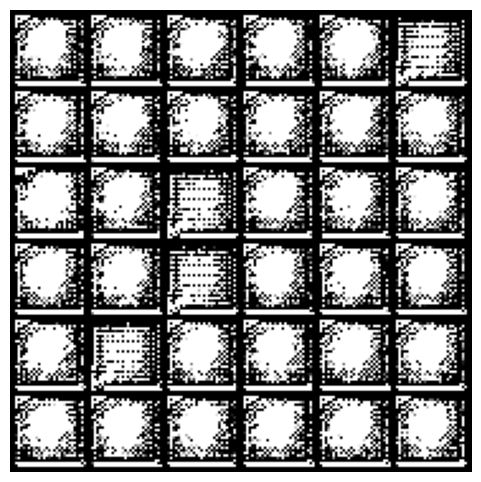

In [ ]:
#@title Sampling
sample_batch_size = 2048
sampler = rdmc_sampler
## Generate samples using the specified sampler.
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [ ]:
#@title FID metric
!pip install scipy
!pip install torch
!pip install torchvision
!pip install pillow
!pip install numpy
!pip install pytorch-fid
!pwd
!mkdir img/real
!mkdir img/fake

import numpy as np
import pytest
import torch
from PIL import Image

from pytorch_fid import fid_score, inception

# import fid_score
# from fid_score import calculate_fid_given_paths
from torchvision.utils import make_grid
import torchvision.utils as vutils

def save_image_list(dataset, real):
    if real:
        base_path = './img/real'
    else:
        base_path = './img/fake'

    dataset_path = []

    for i in range(len(dataset)):
        save_path =  f'{base_path}/image_{i}.png'
        dataset_path.append(save_path)
        vutils.save_image(dataset[i], save_path)

    return base_path

gc.collect()

test_dataset = MNIST(root="./dataset", download=True, train=False,
                                           transform=transforms.Compose([
                                           transforms.ToTensor()]))

sample_batch_size = 2048
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=sample_batch_size, shuffle=True, num_workers=2)
for i, (data, _) in enumerate(dataloader):
    real_dataset = data
    break

# Generate samples using the specified sampler.
fake_dataset = samples

real_image_path_list = save_image_list(real_dataset, True)
fake_image_path_list = save_image_list(fake_dataset, False)

# calculate_fid_given_paths(paths, batch_size, cuda, dims)
fid_value = fid_score.calculate_fid_given_paths([real_image_path_list, fake_image_path_list],
                                                          64,
                                                          device,
                                                          2048)
print (f'FID score: {fid_value}')


In [ ]:
#@title Average bits/dim metric

batch_size = 32 #@param {'type':'integer'}

dataset = MNIST('.', train=False, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

all_bpds = 0.
all_items = 0
try:
  tqdm_data = tqdm.notebook.tqdm(data_loader)
  for x, _ in tqdm_data:
    x = x.to(device)
    x = (x * 255. + torch.rand_like(x)) / 256.
    _, bpd = ode_likelihood(x, score_model, marginal_prob_std_fn,
                            diffusion_coeff_fn,
                            x.shape[0], device=device, eps=1e-5)
    all_bpds += bpd.sum()
    all_items += bpd.shape[0]
    tqdm_data.set_description("Average bits/dim: {:5f}".format(all_bpds / all_items))

except KeyboardInterrupt:
  pass
